In [1]:
import os
import sys
import math
import argparse
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.decomposition import PCA
from typing import Dict, List, Tuple, Iterable, Union, Optional, Set, Sequence, Callable, DefaultDict, Any

# Keras imports
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, PReLU, ELU, ThresholdedReLU, Lambda, Reshape, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, add, concatenate
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Flatten, LSTM, RepeatVector
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D, UpSampling1D, UpSampling2D, UpSampling3D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling1D, AveragePooling2D, AveragePooling3D, Layer
from tensorflow.keras.layers import SeparableConv1D, SeparableConv2D, DepthwiseConv2D, Concatenate, Add
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, GlobalAveragePooling3D


# ml4h Imports
from ml4h.TensorMap import TensorMap
from ml4h.arguments import parse_args
from ml4h.models import make_multimodal_multitask_model, train_model_from_generators, make_hidden_layer_model, _conv_layer_from_kind_and_dimension
from ml4h.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators
from ml4h.recipes import plot_predictions, infer_hidden_layer_multimodal_multitask

# IPython imports
%matplotlib inline
import matplotlib.pyplot as plt


Tensor = tf.Tensor

ACTIVATION_CLASSES = {
    'leaky': LeakyReLU(),
    'prelu': PReLU(),
    'elu': ELU(),
    'thresh_relu': ThresholdedReLU,
}
ACTIVATION_FUNCTIONS = {
    'swish': tf.nn.swish,
    'gelu': tfa.activations.gelu,
    'lisht': tfa.activations.lisht,
    'mish': tfa.activations.mish,
}
NORMALIZATION_CLASSES = {
    'batch_norm': BatchNormalization,
    'layer_norm': LayerNormalization,
    'instance_norm': tfa.layers.InstanceNormalization,
    'poincare_norm': tfa.layers.PoincareNormalize,
}
CONV_REGULARIZATION_CLASSES = {
    # class name -> (dimension -> class)
    'spatial_dropout': {2: SpatialDropout1D, 3: SpatialDropout2D, 4: SpatialDropout3D},
    'dropout': defaultdict(lambda _: Dropout),
}
DENSE_REGULARIZATION_CLASSES = {
    'dropout': Dropout,  # TODO: add l1, l2
}

In [2]:

def _activation_layer(activation: str) -> Activation:
    return (
        ACTIVATION_CLASSES.get(activation, None)
        or Activation(ACTIVATION_FUNCTIONS.get(activation, None) or activation)
    )


def _normalization_layer(norm: str) -> Layer:
    if not norm:
        return lambda x: x
    return NORMALIZATION_CLASSES[norm]()


def _regularization_layer(dimension: int, regularization_type: str, rate: float):
    if not regularization_type:
        return lambda x: x
    if regularization_type in DENSE_REGULARIZATION_CLASSES:
        return DENSE_REGULARIZATION_CLASSES[regularization_type](rate)
    return CONV_REGULARIZATION_CLASSES[regularization_type][dimension](rate)


def _calc_start_shape(
        num_upsamples: int, output_shape: Tuple[int, ...], upsample_rates: Sequence[int], channels: int,
) -> Tuple[int, ...]:
    """
    Given the number of blocks in the decoder and the upsample rates, return required input shape to get to output shape
    """
    upsample_rates = list(upsample_rates) + [1] * len(output_shape)
    return tuple((shape // rate**num_upsamples for shape, rate in zip(output_shape[:-1], upsample_rates))) + (channels,)


class FlatToStructure:
    """Takes a flat input, applies a dense layer, then restructures to output_shape"""
    def __init__(
            self,
            output_shape: Tuple[int, ...],
            activation: str,
            normalization: str,
    ):
        self.input_shapes = output_shape
        self.dense = Dense(units=int(np.prod(output_shape)))
        self.activation = _activation_layer(activation)
        self.reshape = Reshape(output_shape)
        self.norm = _normalization_layer(normalization)

    def __call__(self, x: Tensor) -> Tensor:
        return self.reshape(self.norm(self.activation(self.dense(x))))


def _conv_layer_from_kind_and_dimension(
        dimension: int, conv_layer_type: str, conv_x: List[int], conv_y: List[int], conv_z: List[int],
) -> Tuple[Layer, List[Tuple[int, ...]]]:
    if dimension == 4 and conv_layer_type == 'conv':
        conv_layer = Conv3D
        kernel = zip(conv_x, conv_y, conv_z)
    elif dimension == 3 and conv_layer_type == 'conv':
        conv_layer = Conv2D
        kernel = zip(conv_x, conv_y)
    elif dimension == 2 and conv_layer_type == 'conv':
        conv_layer = Conv1D
        kernel = zip(conv_x)
    elif dimension == 3 and conv_layer_type == 'separable':
        conv_layer = SeparableConv2D
        kernel = zip(conv_x, conv_y)
    elif dimension == 2 and conv_layer_type == 'separable':
        conv_layer = SeparableConv1D
        kernel = zip(conv_x)
    elif dimension == 3 and conv_layer_type == 'depth':
        conv_layer = DepthwiseConv2D
        kernel = zip(conv_x, conv_y)
    else:
        raise ValueError(f'Unknown convolution type: {conv_layer_type} for dimension: {dimension}')
    return conv_layer, list(kernel)


def _upsampler(dimension, pool_x, pool_y, pool_z):
    if dimension == 4:
        return UpSampling3D(size=(pool_x, pool_y, pool_z))
    elif dimension == 3:
        return UpSampling2D(size=(pool_x, pool_y))
    elif dimension == 2:
        return UpSampling1D(size=pool_x)
    

    
def _one_by_n_kernel(dimension):
    return tuple([1] * (dimension - 1))


class DenseConvolutionalBlock:
    def __init__(
            self,
            *,
            dimension: int,
            block_size: int,
            conv_layer_type: str,
            filters: int,
            conv_x: List[int],
            conv_y: List[int],
            conv_z: List[int],
            activation: str,
            normalization: str,
            regularization: str,
            regularization_rate: float,
    ):
        conv_layer, kernels = _conv_layer_from_kind_and_dimension(dimension, conv_layer_type, conv_x, conv_y, conv_z)
        if isinstance(conv_layer, DepthwiseConv2D):
            self.conv_layers = [conv_layer(kernel_size=kernel, padding='same') for kernel in kernels]
        else:
            self.conv_layers = [conv_layer(filters=filters, kernel_size=kernel, padding='same') for kernel in kernels]
        self.activations = [_activation_layer(activation) for _ in range(block_size)]
        self.normalizations = [_normalization_layer(normalization) for _ in range(block_size)]
        self.regularizations = [_regularization_layer(dimension, regularization, regularization_rate) for _ in range(block_size)]
        print(f'Dense Block Convolutional Layers (num_filters, kernel_size): {list(zip([filters]*len(kernels), kernels))}')

    def __call__(self, x: Tensor) -> Tensor:
        dense_connections = [x]
        for i, (convolve, activate, normalize, regularize) in enumerate(
            zip(
                    self.conv_layers, self.activations, self.normalizations, self.regularizations,
            ),
        ):
            x = normalize(regularize(activate(convolve(x))))
            if i < len(self.conv_layers) - 1:  # output of block does not get concatenated to
                dense_connections.append(x)
                x = Concatenate()(dense_connections[:])  # [:] is necessary because of tf weirdness
        return x

    
class ConvDecoder2:
    def __init__(
            self,
            *,
            tensor_map_out: TensorMap,
            filters_per_dense_block: List[int],
            conv_layer_type: str,
            conv_x: List[int],
            conv_y: List[int],
            conv_z: List[int],
            block_size: int,
            activation: str,
            normalization: str,
            regularization: str,
            regularization_rate: float,
            upsample_x: int,
            upsample_y: int,
            upsample_z: int,
    ):
        dimension = tensor_map_out.axes()
        self.dense_blocks = [
            DenseConvolutionalBlock(
                dimension=tensor_map_out.axes(), conv_layer_type=conv_layer_type, filters=filters, conv_x=[x]*block_size,
                conv_y=[y]*block_size, conv_z=[z]*block_size, block_size=block_size, activation=activation, normalization=normalization,
                regularization=regularization, regularization_rate=regularization_rate,
            )
            for filters, x, y, z in zip(filters_per_dense_block, conv_x, conv_y, conv_z)
        ]
        conv_layer, _ = _conv_layer_from_kind_and_dimension(dimension, 'conv', conv_x, conv_y, conv_z)
        self.conv_label = conv_layer(tensor_map_out.shape[-1], _one_by_n_kernel(dimension), activation=tensor_map_out.activation, name=tensor_map_out.output_name())
        self.upsamples = [_upsampler(dimension, upsample_x, upsample_y, upsample_z) for _ in range(len(filters_per_dense_block) + 1)]
        print(f'Decode has: {list(enumerate(zip(self.dense_blocks, self.upsamples)))}')
    def __call__(self, x: Tensor) -> Tensor:
        for i, (dense_block, upsample) in enumerate(zip(self.dense_blocks, self.upsamples)):
            
            x = upsample(x)
            x = dense_block(x)
        return self.conv_label(x)
    
    

In [3]:
from tensorflow.keras.layers import Layer
from tensorflow import acos

def l2_norm(x, axis=None):
    """
    takes an input tensor and returns the l2 norm along specified axis
    """

    square_sum = K.sum(K.square(x), axis=axis, keepdims=True)
    norm = K.sqrt(K.maximum(square_sum, K.epsilon()))

    return norm

def pairwise_cosine_difference(t1, t2):
    """
    A [batch x n x d] tensor of n rows with d dimensions
    B [batch x m x d] tensor of n rows with d dimensions

    returns:
    D [batch x n x m] tensor of cosine similarity scores between each point i<n, j<m
    """
    t1_norm = t1 / l2_norm(t1, axis=-1)
    t2_norm = t2 / l2_norm(t2, axis=-1)
    dot = K.clip(K.batch_dot(t1, t2), -1, 1)
    return acos(dot)

class CosineLossLayer(Layer):
    """Layer that creates an Cosine loss."""
    def __init__(self, weight):
        super(CosineLossLayer, self).__init__()
        self.weight = weight
    def get_config(self):
        config = super().get_config().copy()
        config.update({'weight': self.weight})
        return config
    def call(self, inputs):
        # We use `add_loss` to create a regularization loss
        # that depends on the inputs.
        self.add_loss(self.weight * pairwise_cosine_difference(inputs[0], inputs[1]))
        return inputs

class L2LossLayer(Layer):
    """Layer that creates an L2 loss."""
    def __init__(self, weight):
        super(L2LossLayer, self).__init__()
        self.weight = weight
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({'weight': self.weight})
        return config
    
    def call(self, inputs):
        self.add_loss(self.weight * tf.reduce_sum(tf.square(inputs[0] - inputs[1])))
        return inputs

In [4]:
def make_paired_autoencoder_model(
    pairs: List[Tuple[TensorMap, TensorMap]],
    pair_loss = 'cosine',
    **kwargs
) -> Model:
    inputs = {tm: Input(shape=tm.shape, name=tm.input_name()) for tm in args.tensor_maps_in}
    original_outputs = {tm:1 for tm in args.tensor_maps_out}
    real_serial_layers = kwargs['model_layers']
    args.model_layers = None
    multimodal_activations = []
    encoders = {}
    decoders = {}
    outputs = []
    losses = []
    for left, right in pairs:
        args.tensor_maps_in = [left]
        left_model = make_multimodal_multitask_model(**args.__dict__)
        encode_left = make_hidden_layer_model(left_model, [left], args.hidden_layer)
        h_left = encode_left(inputs[left])
        
        args.tensor_maps_in = [right]
        right_model = make_multimodal_multitask_model(**args.__dict__)     
        encode_right = make_hidden_layer_model(right_model, [right], args.hidden_layer)
        h_right = encode_right(inputs[right])        
        
        if pair_loss == 'cosine':
            loss_layer = CosineLossLayer(1.0)
        elif pair_loss == 'euclid':
            loss_layer = L2LossLayer(1.0)
        
        paired_embeddings = loss_layer([h_left, h_right])
        multimodal_activations.extend(paired_embeddings)
        if left not in encoders:
            encoders[left] = encode_left
        if right not in encoders:
            encoders[right] = encode_right            
        
    multimodal_activation = Concatenate()(multimodal_activations)
    encoder = Model(inputs=list(inputs.values()), outputs=[multimodal_activation], name='encoder')
    
    # build decoder models
    latent_inputs = Input(shape=(args.dense_layers[0]*len(inputs)), name='input_concept_space')
    pre_decoder_shapes: Dict[TensorMap, Optional[Tuple[int, ...]]] = {}
    for tm in args.tensor_maps_out:
        shape = _calc_start_shape(num_upsamples=len(args.dense_blocks), output_shape=tm.shape, 
                                  upsample_rates=[args.pool_x, args.pool_y, args.pool_z], 
                                  channels=args.dense_blocks[-1])    
        
        restructure = FlatToStructure(output_shape=shape, activation=args.activation, 
                                      normalization=args.dense_normalize)
        
        decode = ConvDecoder2(
            tensor_map_out=tm,
            filters_per_dense_block=args.dense_blocks[::-1],
            conv_layer_type=args.conv_type,
            conv_x=args.conv_x,
            conv_y=args.conv_y,
            conv_z=args.conv_z,
            block_size=args.block_size,
            activation=args.activation,
            normalization=args.conv_normalize,
            regularization=args.conv_regularize,
            regularization_rate=args.conv_regularize_rate,
            upsample_x=args.pool_x,
            upsample_y=args.pool_y,
            upsample_z=args.pool_z,
        )
        
        reconstruction = decode(restructure(latent_inputs))
        decoder = Model(latent_inputs, reconstruction, name=tm.output_name())
        decoders[tm] = decoder
        outputs.append(decoder(multimodal_activation))
        losses.append(tm.loss)

    args.tensor_maps_out =  list(original_outputs.keys())
    args.tensor_maps_in = list(inputs.keys())
    
    m = Model(inputs=list(inputs.values()), outputs=outputs)
    my_metrics = {tm.output_name(): tm.metrics for tm in args.tensor_maps_out}
    opt = Adam(lr=kwargs['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    m.compile(optimizer=opt, loss=losses, metrics=my_metrics)
    m.summary()
    
    if real_serial_layers is not None:
        m.load_weights(kwargs['model_layers'], by_name=True)
        print(f"Loaded model weights from:{kwargs['model_layers']}")
        
    return m, encoders, decoders

In [6]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/sax-lax-40k-lvm/2020-01-29/', 
            '--input_tensors', 'ecg.ecg_rest', 'mri.lax_4ch_diastole_slice0_224_3d', 
            '--output_tensors', 'ecg.ecg_rest', 'mri.lax_4ch_diastole_slice0_224_3d',
            '--activation', 'swish',
            '--conv_layers', '32',
            '--conv_x', '3', '3', '3',
            '--conv_y', '3', '3', '3', 
            '--conv_z', '3', '3', '3', 
            '--dense_blocks', '32', '32', '32',
            '--block_size', '3',
            '--dense_layers', '256',
            '--pool_x', '2',
            '--pool_y', '2',
            '--batch_size', '1',
            '--patience', '132',
            '--epochs', '692',
            '--learning_rate', '0.0001',
            '--training_steps', '256',
            '--validation_steps', '30',
            '--test_steps', '2',
            '--num_workers', '4',
            '--inspect_model',
            '--model_layers', './recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/ecg_lax_4c_diastole_pair_euclid_loss.h5',
            '--tensormap_prefix', 'ml4h.tensormap.ukb',
            '--id', 'ecg_lax_4c_diastole_pair_euclid_loss']
args = parse_args()
pairs = [(args.tensor_maps_in[0], args.tensor_maps_in[1])]
overparameterized_model, encoders, decoders = make_paired_autoencoder_model(pairs, pair_loss='euclid', **args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
# train_model_from_generators(
#         overparameterized_model, generate_train, generate_valid, args.training_steps, args.validation_steps, args.batch_size,
#         args.epochs, args.patience, args.output_folder, args.id, args.inspect_model, args.inspect_show_labels,
#         plot=False, save_last_model=True
# )
# for tm in encoders:
#     encoders[tm].save(f'{args.output_folder}{args.id}/encoder_{tm.name}.h5')
# for tm in decoders:
#     decoders[tm].save(f'{args.output_folder}{args.id}/decoder_{tm.name}.h5')

2020-09-23 13:01:02,228 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/log_2020-09-23_13-01_0.log.
2020-09-23 13:01:02,347 - arguments:444 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/sax-lax-40k-lvm/2020-01-29/ --input_tensors ecg.ecg_rest mri.lax_4ch_diastole_slice0_224_3d --output_tensors ecg.ecg_rest mri.lax_4ch_diastole_slice0_224_3d --activation swish --conv_layers 32 --conv_x 3 3 3 --conv_y 3 3 3 --conv_z 3 3 3 --dense_blocks 32 32 32 --block_size 3 --dense_layers 256 --pool_x 2 --pool_y 2 --batch_size 1 --patience 132 --epochs 692 --learning_rate 0.0001 --training_steps 256 --validation_steps 30 --test_steps 2 --num_workers 4 --inspect_model --model_layers ./recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/ecg_lax_4c_diastole_pair_euclid_loss.h5 --tensormap_prefix ml4h.tensormap.ukb --id ecg_lax_4c_diastole_pair_euclid_loss

2020-09-23 13:01:02,349 - arguments

2020-09-23 13:01:04,379 - models:896 - WARNING - Number of x dimensions for convolutional kernel sizes (3) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-09-23 13:01:04,380 - models:896 - WARNING - Number of y dimensions for convolutional kernel sizes (3) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-09-23 13:01:04,381 - models:896 - WARNING - Number of z dimensions for convolutional kernel sizes (3) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-09-23 13:01:04,384 - models:383 - INFO - Residual Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3))]
2020-09-23 13:01:04,391 - models:421 - INFO - Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
2020-09-23 13:01:04,395 - models:421 - INFO - Dense Block Convolutional La

Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3,)), (32, (3,)), (32, (3,))]
Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3,)), (32, (3,)), (32, (3,))]
Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3,)), (32, (3,)), (32, (3,))]
Decode has: [(0, (<__main__.DenseConvolutionalBlock object at 0x7fbba34866d8>, <tensorflow.python.keras.layers.convolutional.UpSampling1D object at 0x7fbba3498668>)), (1, (<__main__.DenseConvolutionalBlock object at 0x7fbba3490048>, <tensorflow.python.keras.layers.convolutional.UpSampling1D object at 0x7fbba34987b8>)), (2, (<__main__.DenseConvolutionalBlock object at 0x7fbba3490ac8>, <tensorflow.python.keras.layers.convolutional.UpSampling1D object at 0x7fbba3498898>))]
Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
Dense Block Convolution

In [7]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/sax-lax-40k-lvm/2020-01-29/', 
            '--tensormap_prefix', 'ml4h.tensormap.ukb',
            '--input_tensors', 'ecg.ecg_rest', 'mri.lax_4ch_diastole_slice0_224_3d', 
            '--output_tensors', 'ecg.ecg_rest', 'mri.lax_4ch_diastole_slice0_224_3d',
            '--batch_size', '1',
            '--test_steps', '8',
            '--hidden_layer', 'concatenate_36',
            '--model_file', './recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/ecg_lax_4c_diastole_pair_euclid_loss.h5',
            '--id', 'ecg_lax_4c_diastole_pair_euclid_loss']
args = parse_args()
#plot_predictions(args)
infer_hidden_layer_multimodal_multitask(args)

2020-09-23 08:57:59,384 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/log_2020-09-23_08-57_0.log.
2020-09-23 08:57:59,386 - arguments:444 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/sax-lax-40k-lvm/2020-01-29/ --tensormap_prefix ml4h.tensormap.ukb --input_tensors ecg.ecg_rest mri.lax_4ch_diastole_slice0_224_3d --output_tensors ecg.ecg_rest mri.lax_4ch_diastole_slice0_224_3d --batch_size 1 --test_steps 8 --hidden_layer concatenate_36 --model_file ./recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/ecg_lax_4c_diastole_pair_euclid_loss.h5 --id ecg_lax_4c_diastole_pair_euclid_loss

2020-09-23 08:57:59,388 - arguments:445 - INFO - Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=1, bigquery_credentials_file='/mnt/ml4cvd/projects/james

2020-09-23 09:13:35,993 - recipes:330 - INFO - Wrote:4000 rows of latent space inference.  Last tensor:/mnt/disks/sax-lax-40k-lvm/2020-01-29/3636145.hd5
2020-09-23 09:15:34,488 - recipes:330 - INFO - Wrote:4500 rows of latent space inference.  Last tensor:/mnt/disks/sax-lax-40k-lvm/2020-01-29/3870791.hd5
2020-09-23 09:17:50,707 - recipes:330 - INFO - Wrote:5000 rows of latent space inference.  Last tensor:/mnt/disks/sax-lax-40k-lvm/2020-01-29/4363943.hd5
2020-09-23 09:19:43,294 - recipes:330 - INFO - Wrote:5500 rows of latent space inference.  Last tensor:/mnt/disks/sax-lax-40k-lvm/2020-01-29/4593772.hd5
2020-09-23 09:21:27,435 - recipes:330 - INFO - Wrote:6000 rows of latent space inference.  Last tensor:/mnt/disks/sax-lax-40k-lvm/2020-01-29/4716008.hd5
2020-09-23 09:23:24,915 - recipes:330 - INFO - Wrote:6500 rows of latent space inference.  Last tensor:/mnt/disks/sax-lax-40k-lvm/2020-01-29/4947155.hd5
2020-09-23 09:25:19,327 - recipes:330 - INFO - Wrote:7000 rows of latent space inf

2020-09-23 09:31:11,803 - recipes:318 - INFO - Latent space inference on 8489 tensors finished. Inference TSV file at: ./recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/hidden_inference_ecg_lax_4c_diastole_pair_euclid_loss.tsv


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8489 entries, 0 to 8488
Columns: 550 entries, 21003_Age-when-attended-assessment-centre_2_0 to latent_511
dtypes: float64(547), int64(2), object(1)
memory usage: 35.7+ MB


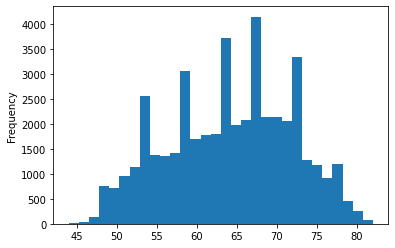

In [7]:
hidden_inference = './recipes_output/lax_2ch_3ch_diastole_paired_autoencoder_swish/hidden_inference_lax_2ch_3ch_diastole_paired_autoencoder_swish.tsv'
hidden_inference = './recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/hidden_inference_ecg_lax_4c_diastole_pair_euclid_loss.tsv'
df = pd.read_csv('/home/sam/ml/trained_models/lax_4ch_diastole_autoencode_leaky_converge/tensors_all_union.csv')
df['21003_Age-when-attended-assessment-centre_2_0'].plot.hist(bins=30)

df2 = pd.read_csv(hidden_inference, sep='\t')
df['fpath'] = pd.to_numeric(df['fpath'], errors='coerce')
df2['sample_id'] = pd.to_numeric(df2['sample_id'], errors='coerce')
#df.info()
latent_df = pd.merge(df, df2, left_on='fpath', right_on='sample_id', how='inner')
# #latent_df.info()
# df3 = pd.read_csv('/home/sam/tsvs/ttn_disease.tsv', sep='\t')
# df4 = pd.read_csv('/home/sam/csvs/has_exome.csv')
# latent_df = pd.merge(df3, latent_df, left_on='sample_id', right_on='sample_id', how='right')
# 
# print(latent_df['has_ttntv'].value_counts())
latent_df.info()

In [8]:
out_path = os.path.join(args.output_folder, args.id + '/')
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(generate_test, args.test_steps*5)
print(list(test_data.keys()))

preds = overparameterized_model.predict(test_data)
print([p.shape for p in preds])
print([tm.name for tm in args.tensor_maps_out])
print(test_paths)

2020-09-23 13:01:32,554 - tensor_generators:151 - INFO - Started 4 test workers with cache size 0.0GB.
2020-09-23 13:01:33,128 - tensor_generators:504 - INFO - Made a big batch of tensors with key:input_strip_continuous and shape:(10, 5000, 12).
2020-09-23 13:01:33,129 - tensor_generators:504 - INFO - Made a big batch of tensors with key:input_lax_4ch_diastole_slice0_224_3d_continuous and shape:(10, 160, 224, 1).
2020-09-23 13:01:33,130 - tensor_generators:504 - INFO - Made a big batch of tensors with key:output_strip_continuous and shape:(10, 5000, 12).
2020-09-23 13:01:33,131 - tensor_generators:504 - INFO - Made a big batch of tensors with key:output_lax_4ch_diastole_slice0_224_3d_continuous and shape:(10, 160, 224, 1).
['input_strip_continuous', 'input_lax_4ch_diastole_slice0_224_3d_continuous']
[(10, 5000, 12), (10, 160, 224, 1)]
['strip', 'lax_4ch_diastole_slice0_224_3d']
['/mnt/disks/sax-lax-40k-lvm/2020-01-29/3373794.hd5', '/mnt/disks/sax-lax-40k-lvm/2020-01-29/3845858.hd5', '/

In [9]:
from ml4h.plots import _plot_reconstruction
_plot_reconstruction(args.tensor_maps_out[0],  test_data['input_strip_continuous'], preds[0], out_path, test_paths, num_samples=2)
from ml4h.explorations import predictions_to_pngs
predictions_to_pngs(preds, args.tensor_maps_in, args.tensor_maps_out, 
                    test_data, test_labels, test_paths, out_path)



2020-09-23 13:01:35,937 - plots:2081 - INFO - Plotting 2 reconstructions of TensorMap(strip, (5000, 12), continuous).
2020-09-23 13:01:40,405 - explorations:57 - INFO - Write predictions as PNGs TensorMap:strip, y shape:(10, 5000, 12) labels:(10, 5000, 12) folder:./recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/
2020-09-23 13:02:02,263 - explorations:57 - INFO - Write predictions as PNGs TensorMap:lax_4ch_diastole_slice0_224_3d, y shape:(10, 160, 224, 1) labels:(10, 160, 224, 1) folder:./recipes_output/ecg_lax_4c_diastole_pair_euclid_loss/


<Figure size 576x1152 with 0 Axes>

<Figure size 576x1152 with 0 Axes>

<Figure size 576x1728 with 0 Axes>

In [10]:
for i, etm in enumerate(encoders):
    embed = encoders[etm].predict(test_data[etm.input_name()])
    double = np.tile(embed, 2)
    print(f'embed shape: {embed.shape} double shape: {double.shape}')
    for dtm in decoders:
        predictions = decoders[dtm].predict(double)
        print(f'prediction shape: {predictions.shape}')
        out_path = os.path.join(args.output_folder, args.id, f'decoding_{dtm.name}_from_{etm.name}/')
        if not os.path.exists(os.path.dirname(out_path)):
            os.makedirs(os.path.dirname(out_path))
        _plot_reconstruction(dtm, test_data[dtm.input_name()], predictions.copy(), out_path, test_paths, 8)

embed shape: (10, 256) double shape: (10, 512)
prediction shape: (10, 5000, 12)
2020-09-23 13:02:03,702 - plots:2081 - INFO - Plotting 8 reconstructions of TensorMap(strip, (5000, 12), continuous).
prediction shape: (10, 160, 224, 1)
2020-09-23 13:02:25,251 - plots:2081 - INFO - Plotting 8 reconstructions of TensorMap(lax_4ch_diastole_slice0_224_3d, (160, 224, 1), continuous).
embed shape: (10, 256) double shape: (10, 512)
prediction shape: (10, 5000, 12)
2020-09-23 13:02:25,628 - plots:2081 - INFO - Plotting 8 reconstructions of TensorMap(strip, (5000, 12), continuous).
prediction shape: (10, 160, 224, 1)
2020-09-23 13:02:47,509 - plots:2081 - INFO - Plotting 8 reconstructions of TensorMap(lax_4ch_diastole_slice0_224_3d, (160, 224, 1), continuous).


<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

<Figure size 576x4608 with 0 Axes>

In [12]:
def pca_on_matrix(matrix, pca_components):
    pca = PCA()
    pca.fit(matrix)
    print(f'PCA explains {100*np.sum(pca.explained_variance_ratio_[:pca_components]):0.1f}% of variance with {pca_components} top PCA components.')
    matrix_reduced = pca.transform(matrix)[:, :pca_components]
    print(f'PCA reduces matrix shape:{matrix_reduced.shape} from matrix shape: {matrix.shape}')
    plot_scree(pca_components, 100*pca.explained_variance_ratio_)
    return pca, matrix_reduced

def plot_scree(pca_components, percent_explained):
    _ = plt.figure(figsize=(6, 4))
    plt.plot(range(len(percent_explained)), percent_explained, 'g.-', linewidth=1)
    plt.axvline(x=pca_components, c='r', linewidth=3)
    label = f'{np.sum(percent_explained[:pca_components]):0.1f}% of variance explained by top {pca_components} of {len(percent_explained)} components'
    plt.text(pca_components+0.02*len(percent_explained), percent_explained[1], label)
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('% of Variance Explained by Each Component')
    figure_path = f'./results/pca_{pca_components}_of_{len(percent_explained)}_testimonials.png'
    if not os.path.exists(os.path.dirname(figure_path)):
        os.makedirs(os.path.dirname(figure_path))
    plt.savefig(figure_path)
    
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def directions_in_latent_space(stratify_column, stratify_thresh, split_column, split_thresh, latent_cols, latent_df):
    hit = latent_df.loc[latent_df[stratify_column] >= stratify_thresh][latent_cols].to_numpy()
    miss = latent_df.loc[latent_df[stratify_column] < stratify_thresh][latent_cols].to_numpy()
    miss_mean_vector = np.mean(miss, axis=0)
    hit_mean_vector = np.mean(hit, axis=0)
    strat_vector = hit_mean_vector - miss_mean_vector
    
    hit1 = latent_df.loc[(latent_df[stratify_column] >= stratify_thresh) 
                        & (latent_df[split_column] >= split_thresh)][latent_cols].to_numpy()
    miss1 = latent_df.loc[(latent_df[stratify_column] < stratify_thresh) 
                        & (latent_df[split_column] >= split_thresh)][latent_cols].to_numpy()
    hit2 = latent_df.loc[(latent_df[stratify_column] >= stratify_thresh) 
                        & (latent_df[split_column] < split_thresh)][latent_cols].to_numpy()
    miss2 = latent_df.loc[(latent_df[stratify_column] < stratify_thresh) 
                        & (latent_df[split_column] < split_thresh)][latent_cols].to_numpy()
    miss_mean_vector1 = np.mean(miss1, axis=0)
    hit_mean_vector1 = np.mean(hit1, axis=0)
    angle1 = angle_between(miss_mean_vector1, hit_mean_vector1)
    miss_mean_vector2 = np.mean(miss2, axis=0)
    hit_mean_vector2 = np.mean(hit2, axis=0)
    angle2 = angle_between(miss_mean_vector2, hit_mean_vector2)
    h1_vector = hit_mean_vector1-miss_mean_vector1
    h2_vector = hit_mean_vector2-miss_mean_vector2
    angle3 = angle_between(h1_vector, h2_vector)
    angle4 = angle_between(strat_vector, h1_vector)
    angle5 = angle_between(strat_vector, h2_vector)
    print(f'\n Between {stratify_column}, and splits: {split_column}\n',
          f'Angles: {angle1:.4f}, {angle2:.4f} \n'
          f'stratify threshold: {stratify_thresh}, split thresh: {split_thresh}, \n'
          f'hit_mean_vector2 shape {miss_mean_vector1.shape}, miss1:{hit_mean_vector2.shape} \n'
          f'Hit1 shape {hit1.shape}, miss1:{miss1.shape} threshold:{stratify_thresh}\n'
          f'Hit2 shape {hit2.shape}, miss2:{miss2.shape}\n')

    return hit_mean_vector1, miss_mean_vector1, hit_mean_vector2, miss_mean_vector2
    
def stratify_latent_space(stratify_column, stratify_thresh, latent_cols, latent_df):
    hit = latent_df.loc[latent_df[stratify_column] >= stratify_thresh][latent_cols].to_numpy()
    miss = latent_df.loc[latent_df[stratify_column] < stratify_thresh][latent_cols].to_numpy()
    miss_mean_vector = np.mean(miss, axis=0)
    hit_mean_vector = np.mean(hit, axis=0)
    angle = angle_between(miss_mean_vector, hit_mean_vector)
    print(f'Angle between {stratify_column} and all others: {angle}, \n'
          f'Hit shape {hit.shape}, miss:{miss.shape} threshold:{stratify_thresh}\n'
          f'Distance: {np.linalg.norm(hit_mean_vector-miss_mean_vector):.3f}, Hit std {np.std(hit, axis=1).mean():.3f}, miss std:{np.std(miss, axis=1).mean():.3f}\n')
    return hit_mean_vector, miss_mean_vector
    

def plot_pcs(sides, color_key):
    f, axes = plt.subplots(sides, sides, figsize=(16, 16))
    for i, ax in enumerate(axes.ravel()):
        colors = latent_df[color_key].to_numpy()
        points = ax.scatter(matrix_reduce[:, i], matrix_reduce[:, i+1], c=colors)
        f.colorbar(points, ax=ax)
        



In [ ]:
import matplotlib.pyplot as plt
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
pca, matrix_reduce = pca_on_matrix(df2[latent_cols].to_numpy(), 10)
for strat in ['Sex_Female_0_0', 'atrial_fibrillation_or_flutter', 
              'coronary_artery_disease', 'hypertension']:
    stratify_latent_space(strat, 1.0, latent_cols, latent_df)
strats = ['LVEF', 'LVM', 'LVEDV', 'sample_id',
              '21001_Body-mass-index-BMI_0_0', '21003_Age-when-attended-assessment-centre_2_0']
theshes = [45, 100, 150, 3500000, 27.5, 70]
for strat, thresh in zip(strats, theshes):
    stratify_latent_space(strat, thresh, latent_cols, latent_df)

In [ ]:
latent_dimension = 256
latent_cols = [f'latent_{256+i}' for i in range(latent_dimension)]
pca, matrix_reduce = pca_on_matrix(df2[latent_cols].to_numpy(), 10)
for strat in ['Sex_Female_0_0', 'atrial_fibrillation_or_flutter', 
              'coronary_artery_disease', 'hypertension']:
    stratify_latent_space(strat, 1.0, latent_cols, latent_df)
strats = ['LVEF', 'LVM', 'LVEDV', 'sample_id',
              '21001_Body-mass-index-BMI_0_0', '21003_Age-when-attended-assessment-centre_2_0']
theshes = [45, 100, 150, 1250000, 27.5, 70]
for strat, thresh in zip(strats, theshes):
    stratify_latent_space(strat, thresh, latent_cols, latent_df)

In [ ]:
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
ch2_encode = df2[latent_cols].to_numpy()
latent_cols = [f'latent_{256+i}' for i in range(latent_dimension)]
ch3_encode = df2[latent_cols].to_numpy()
sqr_diff = (ch2_encode - ch3_encode) * (ch2_encode - ch3_encode)
print(sqr_diff.shape)
sum_sqr_diff = np.mean(np.sqrt(np.sum(sqr_diff, axis=-1)))
print(sum_sqr_diff)

In [ ]:
print(f'{ch2_encode[:5,:5]} \n{ch3_encode[:5,:5]}')

In [ ]:
ch2_random = np.random.random((4452, 256))
ch3_random = np.random.random((4452, 256))
sqr_diff = (ch2_random - ch3_random) * (ch2_random - ch3_random)
print(sqr_diff.shape)
sum_sqr_diff = np.mean(np.sqrt(np.sum(sqr_diff, axis=-1)))
print(sum_sqr_diff)

In [ ]:
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
ch2_encode = df2[latent_cols].to_numpy()
latent_cols = [f'latent_{98+i}' for i in range(latent_dimension)]
ch3_encode = df2[latent_cols].to_numpy()
sqr_diff = (ch2_encode - ch3_encode) * (ch2_encode - ch3_encode)
print(sqr_diff.shape)
sum_sqr_diff = np.mean(np.sqrt(np.sum(sqr_diff, axis=-1)))
print(sum_sqr_diff)

In [33]:
latent_dimension = 256
latent_cols = [f'latent_{256+i}' for i in range(latent_dimension)]
female, male = stratify_latent_space('Sex_Female_0_0', 1.0, latent_cols, latent_df)
sex_vector = female - male
print(f'sex vector shape: {sex_vector.shape}')

Angle between Sex_Female_0_0 and all others: 2.221477455583167, 
Hit shape (4380, 256), miss:(4109, 256) threshold:1.0
Distance: 0.017, Hit std 0.004, miss std:0.004

sex vector shape: (256,)


In [25]:
def _figure_and_subplot_axes_from_total(total_plots: int):
    cols = max(2, int(math.ceil(math.sqrt(total_plots))))
    rows = max(2, int(math.ceil(total_plots / cols)))
    return plt.subplots(rows, cols, figsize=(cols * 8, rows * 8))

l shape: (16, 256) sexes  shape: (16,)
double shape: (16, 512) sex_vectors  shape: (16, 512)
prediction shape: (16, 5000, 12)
prediction shape: (16, 160, 224, 1)


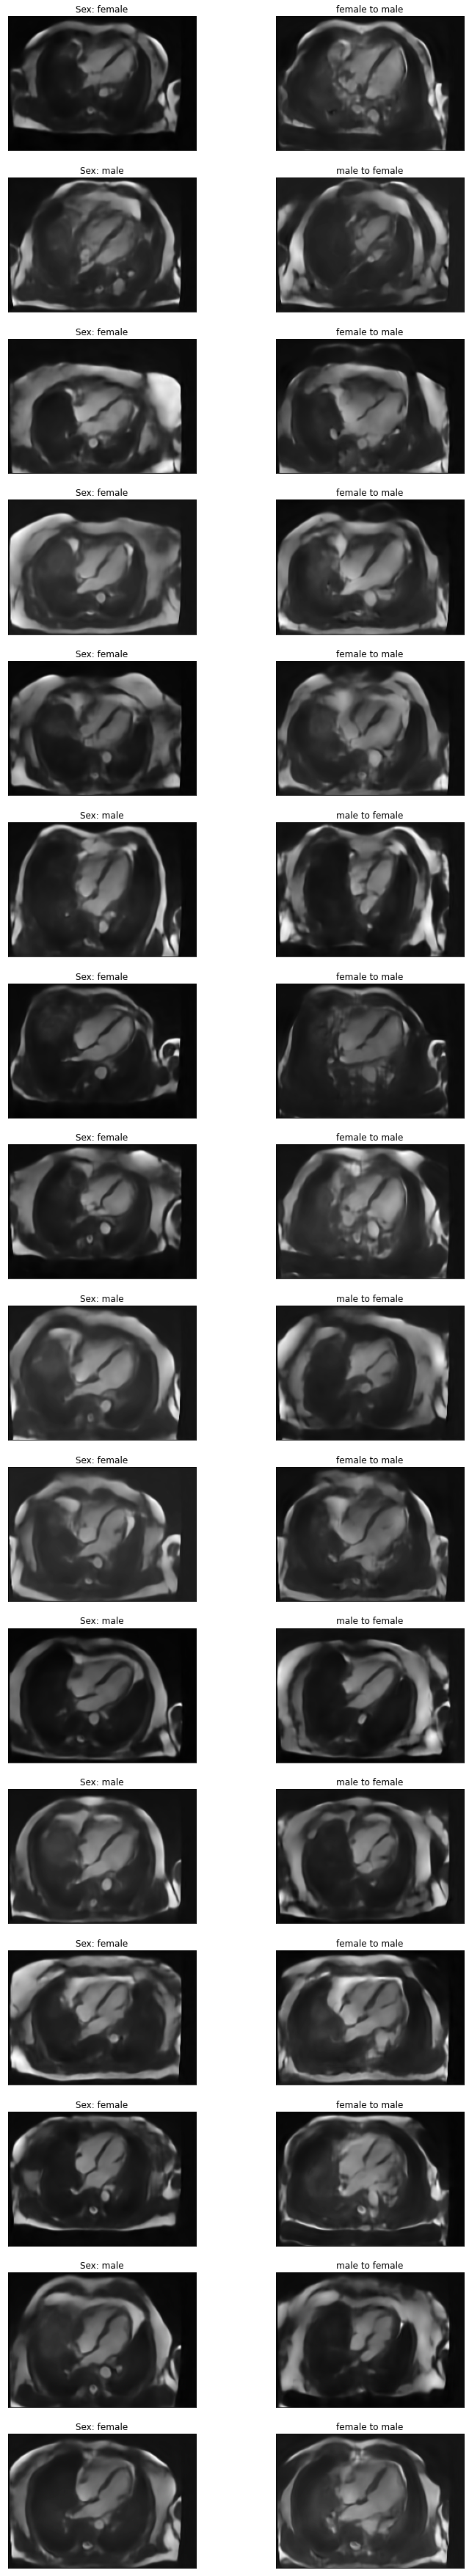

In [47]:
samples = 16
l = latent_df.iloc[:samples][latent_cols].to_numpy()
sexes = latent_df.iloc[:samples]['Sex_Female_0_0'].to_numpy()
print(f'l shape: {l.shape} sexes  shape: {sexes.shape}')
sex_vectors =  np.tile(sex_vector, (samples, 2))
double = np.tile(l, 2)
male_to_female = double + (3 * sex_vectors)
female_to_male = double - (3 * sex_vectors)
print(f'double shape: {double.shape} sex_vectors  shape: {sex_vectors.shape}')
for dtm in decoders:
    predictions = decoders[dtm].predict(double)
    m2f = decoders[dtm].predict(male_to_female)
    f2m = decoders[dtm].predict(female_to_male)
    print(f'prediction shape: {predictions.shape}')
    if dtm.axes() ==  3:
        fig, axes = plt.subplots(samples, 2, figsize=(12, samples * 4))
        for i in range(samples):
            axes[i, 0].imshow(predictions[i, ..., 0], cmap='gray')
            sex_str = 'female' if sexes[i] else 'male'
            axes[i, 0].set_title(f"Sex: {sex_str}")
            axes[i, 0].set_xticks(())
            axes[i, 0].set_yticks(())
            axes[i, 1].set_xticks(())
            axes[i, 1].set_yticks(())
            if sexes[i]:
                axes[i, 1].imshow(f2m[i, ..., 0], cmap = 'gray')
                axes[i, 1].set_title(f'{sex_str} to male')                
            else:
                axes[i, 1].imshow(m2f[i, ..., 0], cmap = 'gray')
                axes[i, 1].set_title(f'{sex_str} to female')   


l shape: (16, 256) sexes  shape: (16,)
double shape: (16, 512) sex_vectors  shape: (16, 512)
prediction shape: (1, 5000, 12)
prediction shape: (1, 160, 224, 1)


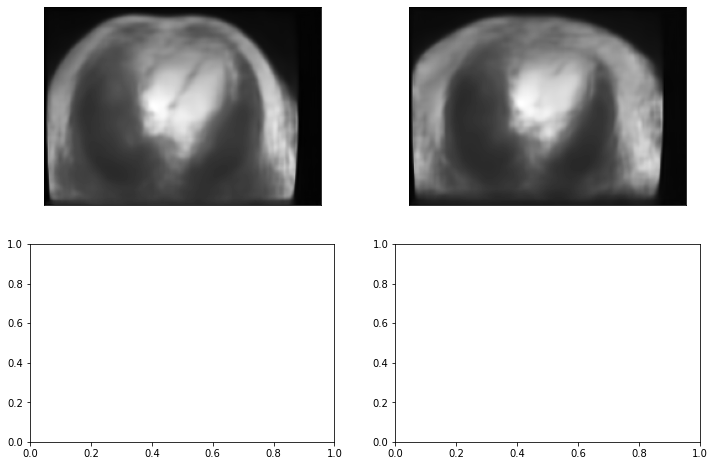

In [55]:
old_female, old_male, young_female, young_male = directions_in_latent_space('Sex_Female_0_0', 1.0, '21003_Age-when-attended-assessment-centre_2_0', 65, latent_cols, latent_df)


 Between Sex_Female_0_0, and splits: 21003_Age-when-attended-assessment-centre_2_0
 Angles: 2.1735, 2.1393 
stratify threshold: 1.0, split thresh: 65, 
hit_mean_vector2 shape (256,), miss1:(256,) 
Hit1 shape (1926, 256), miss1:(2141, 256) threshold:1.0
Hit2 shape (2454, 256), miss2:(1968, 256)



prediction shape: (1, 160, 224, 1)
prediction shape: (1, 160, 224, 1)


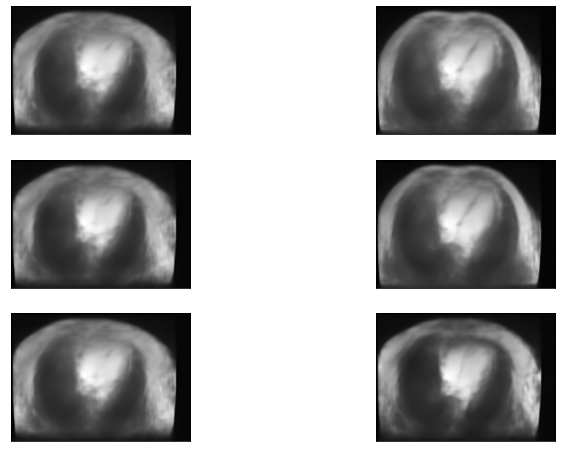

In [57]:
vectors = [
    old_female, old_male, young_female, young_male, old_female,
    old_female + 3*(young_male - old_male), old_male + 3*(young_female - old_female)
          ]
for dtm in decoders:
    
    mean_female = decoders[dtm].predict(np.expand_dims(np.tile(female, 2), axis = 0))
    print(f'prediction shape: {mean_male.shape}')
    if dtm.axes() ==  3:
        fig, axes = plt.subplots(3, 2, figsize=(12, 8))
        for vector, ax in zip(vectors, axes.ravel()):
            reconstruct = decoders[dtm].predict(np.expand_dims(np.tile(vector, 2), axis = 0))
            ax.imshow(reconstruct[0, ..., 0], cmap='gray')
            ax.set_xticks(())
            ax.set_yticks(())

In [71]:
def plot_hit_to_miss_transforms(latent_df, feature='Sex_Female_0_0', 
                                thresh = 1.0, latent_dimension = 256, samples = 16):
    latent_cols = [f'latent_{256+i}' for i in range(latent_dimension)]
    female, male = stratify_latent_space(feature, thresh, latent_cols, latent_df)
    sex_vector = female - male
    print(f'sex vector shape: {sex_vector.shape}')
    l = latent_df.iloc[:samples][latent_cols].to_numpy()
    sexes = latent_df.iloc[:samples][feature].to_numpy()
    print(f'l shape: {l.shape} sexes  shape: {sexes.shape}')
    sex_vectors =  np.tile(sex_vector, (samples, 2))
    double = np.tile(l, 2)
    male_to_female = double + (8 * sex_vectors)
    female_to_male = double - (8 * sex_vectors)
    print(f'double shape: {double.shape} sex_vectors  shape: {sex_vectors.shape}')
    for dtm in decoders:
        predictions = decoders[dtm].predict(double)
        m2f = decoders[dtm].predict(male_to_female)
        f2m = decoders[dtm].predict(female_to_male)
        print(f'prediction shape: {predictions.shape}')
        if dtm.axes() ==  3:
            fig, axes = plt.subplots(samples, 2, figsize=(18, samples * 4))
            for i in range(samples):
                axes[i, 0].imshow(predictions[i, ..., 0], cmap='gray')
                axes[i, 0].set_title(f"{feature}: {sexes[i]} ?>=<? {thresh}")
                axes[i, 0].set_xticks(())
                axes[i, 0].set_yticks(())
                axes[i, 1].set_xticks(())
                axes[i, 1].set_yticks(())
                if sexes[i] >= thresh:
                    axes[i, 1].imshow(f2m[i, ..., 0], cmap = 'gray')
                    axes[i, 1].set_title(f'{feature} to less than {thresh}')                
                else:
                    axes[i, 1].imshow(m2f[i, ..., 0], cmap = 'gray')
                    axes[i, 1].set_title(f'{feature} to more than {thresh}')   



Angle between Sex_Female_0_0 and all others: 2.221477455583167, 
Hit shape (4380, 256), miss:(4109, 256) threshold:1.0
Distance: 0.017, Hit std 0.004, miss std:0.004

sex vector shape: (256,)
l shape: (16, 256) sexes  shape: (16,)
double shape: (16, 512) sex_vectors  shape: (16, 512)
prediction shape: (16, 5000, 12)
prediction shape: (16, 160, 224, 1)


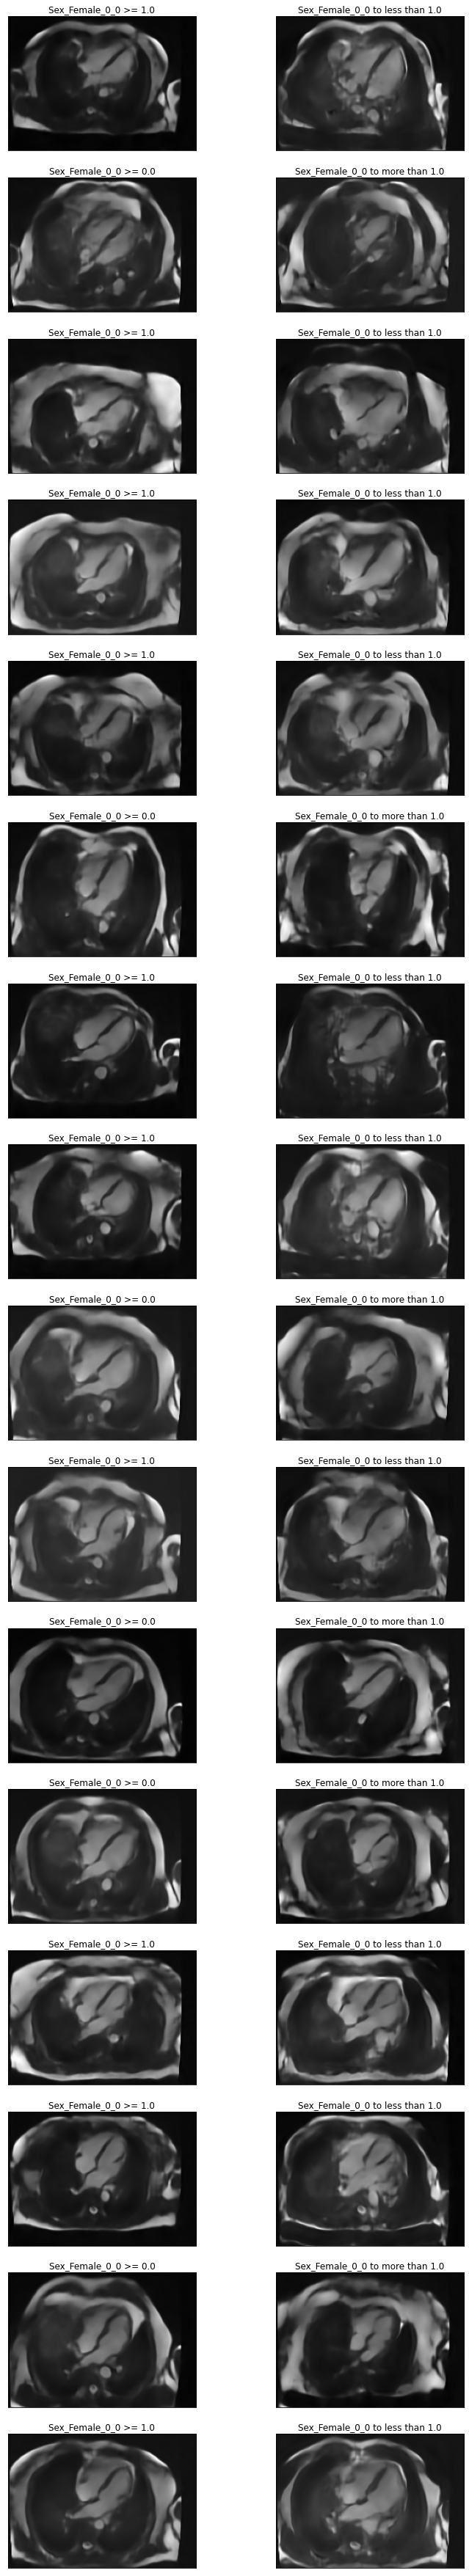

In [59]:
plot_hit_to_miss_transforms(latent_df, feature='Sex_Female_0_0', 
                                thresh = 1.0, latent_dimension = 256, samples = 16)

Angle between 21003_Age-when-attended-assessment-centre_2_0 and all others: 0.8696728126155765, 
Hit shape (4067, 256), miss:(4422, 256) threshold:65.0
Distance: 0.004, Hit std 0.004, miss std:0.004

sex vector shape: (256,)
l shape: (16, 256) sexes  shape: (16,)
double shape: (16, 512) sex_vectors  shape: (16, 512)
prediction shape: (16, 5000, 12)
prediction shape: (16, 160, 224, 1)


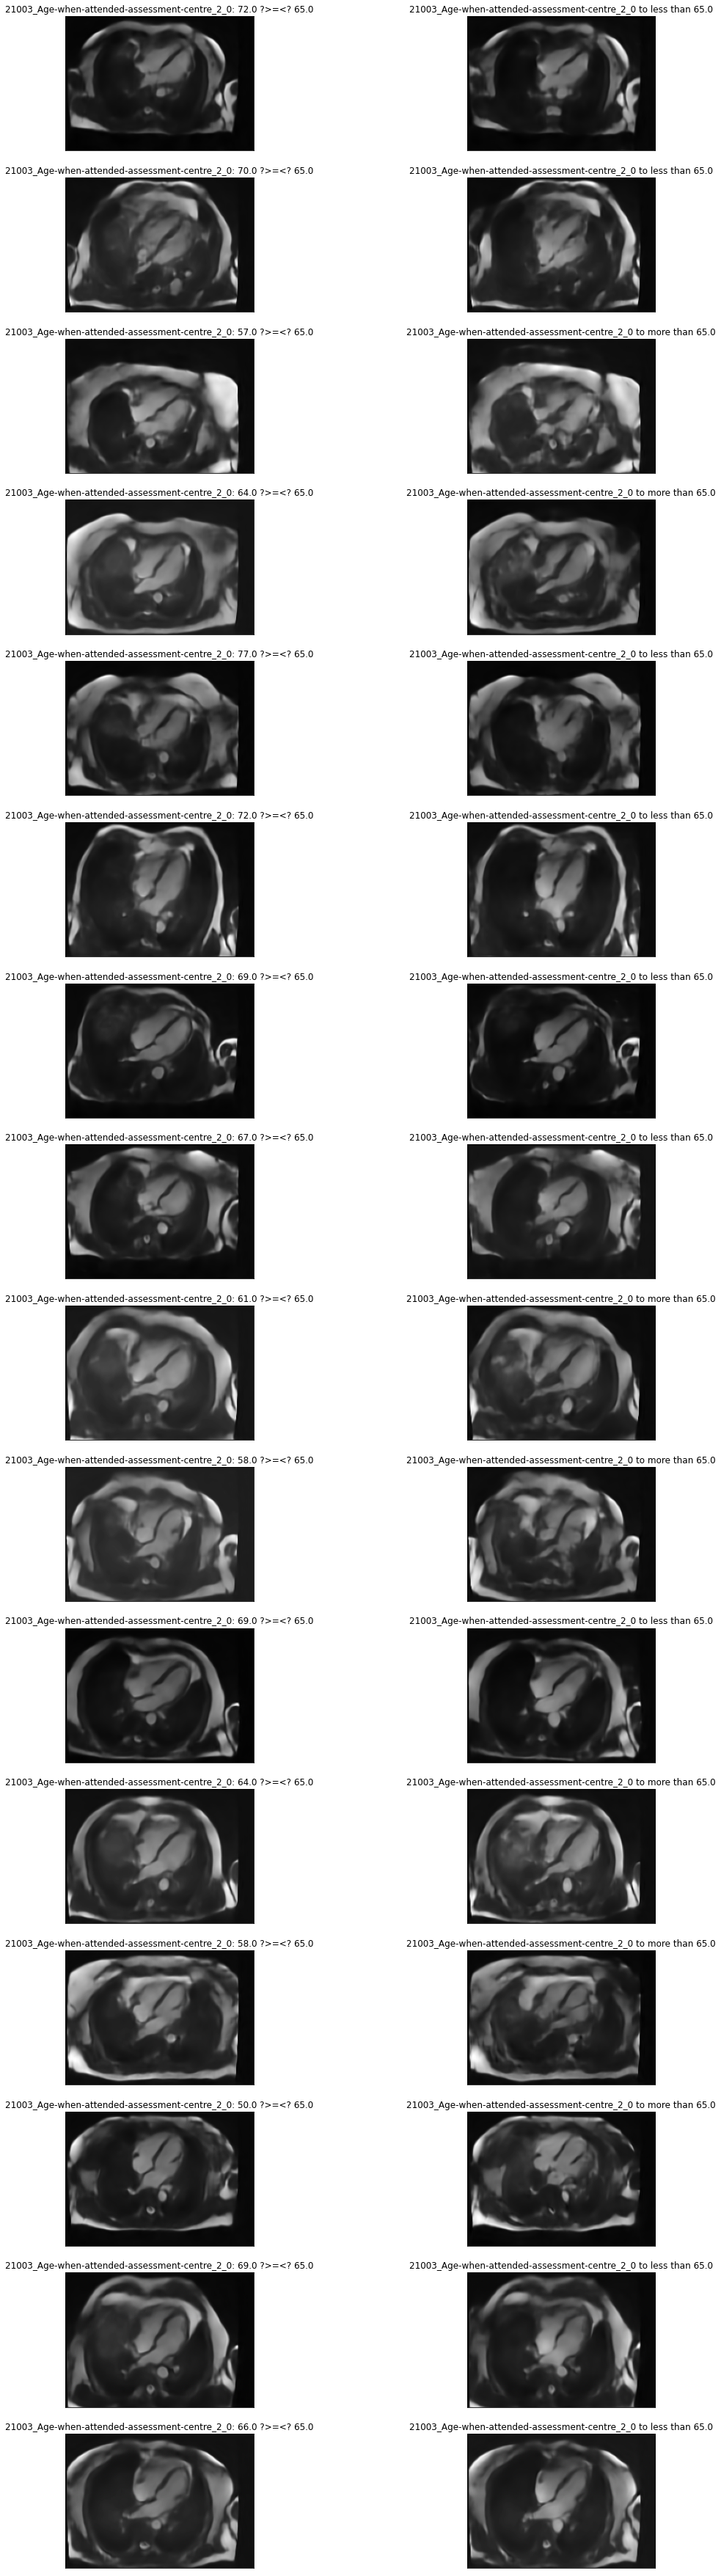

In [73]:
plot_hit_to_miss_transforms(latent_df, feature='21003_Age-when-attended-assessment-centre_2_0', 
                                thresh = 65.0, latent_dimension = 256, samples = 16)